# Keypoint Detection using YOLO v7 #

In [11]:
import sys
import torch
import torchvision
import cv2
import yaml
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import os
sys.path.append("FishVision")

!nvidia-smi

Mon Apr 24 12:30:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:57:00.0 Off |                    0 |
| N/A   32C    P0    71W / 350W |   2538MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# YOLO v7 setup

%cd /home/tanjan/FishVision/yolov7

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

# testing YOLO setup with inference
#!python detect.py --weights yolov7.pt --source inference/images/horses.jpg --img 640

/home/tanjan/FishVision/yolov7


## Testing for human keypoint detection with pretrained model and weights ##

In [3]:
# initialize for CUDA with pretrained pose estimation weights for human model test

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [4]:
testimage = 'Pontatal-86klein.jpg'

image = cv2.imread(testimage)
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

if torch.cuda.is_available():
    image = image.half().to(device)   
output, _ = model(image)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:599: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2299.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
with torch.no_grad():
    output = output_to_keypoint(output)
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
for idx in range(output.shape[0]):
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

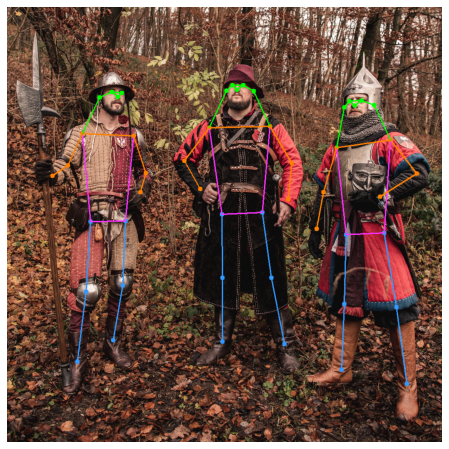

In [6]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(nimg)
plt.show()

## Application for Fish Keypoint Detection ##

* ensure that keypoints are in COCO annotation format
* split data into test/train
* transfer learning: keep model and weights of yolov7-w6-pose.pt and test on fish: nothing happens, no keypoints found
* new annotations
* adapt train.py to take in new keypoints and training data

In [27]:
# keypoint conversion from COCO to YOLO v7 format
# converting the ultralytics JSON2YOLO converter at https://github.com/ultralytics/JSON2YOLO for additional keypoint data
# format: class, x_center, y_center, width, height, kpt1_x, kpt1_y, visibility_1, ..., kptn_x, kptn_y, visibility_n

import itertools
import general_JSON2YOLO as jtyo 
import importlib
importlib.reload(jtyo)

# TODO: In jtyo, shift bounding box by one pixel each direction to simulate an actual cutout to produce normalized 

jtyo.convert_coco_json('/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct', '/home/tanjan/FishVision/data')
# move labels to correct folder afterwards

# computed

/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct


Annotations /home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/annotations.json:  12%|█▏        | 58/468 [00:00<00:00, 568.14it/s]

box:  [          0           0         603         135]
1.0
1.0
602.0
134.0
[         27          48           2          58          74           2          30          61           2          52          56           2          78          28           2         121          79           2         110          98           2         118          97           2         244          21
           2         341          32           2         283         124           2         407         111           2         445          98           2         441          55           2         470          62           2         494          66           2         515          53           2         540
          77           2         521          99           2         502          94           2]
[   0.044776     0.35556           2    0.096186     0.54815           2    0.049751     0.45185           2    0.086235     0.41481           2     0.12935     0.20741           2     0.20066     0.5

Annotations /home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/annotations.json:  39%|███▊      | 181/468 [00:00<00:00, 587.87it/s]

 (0, 0.5009259259259259, 0.503968253968254, 0.9981481481481481, 0.9920634920634921, 0.04814814814814815, 0.3253968253968254, 2.0, 0.09814814814814815, 0.5158730158730159, 2.0, 0.05185185185185185, 0.42063492063492064, 2.0, 0.10185185185185185, 0.38095238095238093, 2.0, 0.15185185185185185, 0.19047619047619047, 2.0, 0.19814814814814816, 0.5793650793650794, 2.0, 0.1814814814814815, 0.7063492063492064, 2.0, 0.1925925925925926, 0.7063492063492064, 2.0, 0.39444444444444443, 0.12698412698412698, 2.0, 0.512962962962963, 0.20634920634920634, 2.0, 0.4703703703703704, 0.9047619047619048, 2.0, 0.6666666666666666, 0.8412698412698413, 2.0, 0.7333333333333333, 0.7301587301587301, 2.0, 0.7222222222222222, 0.4126984126984127, 2.0, 0.762962962962963, 0.46825396825396826, 2.0, 0.8166666666666667, 0.5079365079365079, 2.0, 0.8574074074074074, 0.4523809523809524, 2.0, 0.8888888888888888, 0.6507936507936508, 2.0, 0.8537037037037037, 0.8253968253968254, 2.0, 0.8111111111111111, 0.7301587301587301, 2.0)
box: 

Annotations /home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/annotations.json:  65%|██████▍   | 302/468 [00:00<00:00, 579.51it/s]

box:  [          0           0         723         175]
1.0
1.0
722.0
174.0
[         34          85           2          67         110           2          34         100           2          73          95           2         110          58           2         149         118           2         125         139           2         140         136           2         292          30
           2         378          41           2         322         157           2         458         136           2         502         127           2         505          62           2         531          71           2         563          81           2         598          70           2         617
         100           2         594         125           2         561         115           2]
[   0.047026     0.48571           2    0.092669     0.62857           2    0.047026     0.57143           2     0.10097     0.54286           2     0.15214     0.33143           2     0.20609     0.6

Annotations /home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/annotations.json: 100%|██████████| 468/468 [00:00<00:00, 591.51it/s]

box:  [          0           0         795         207]
1.0
1.0
794.0
206.0
[         35         122           2          71         145           2          37         136           2          72         126           2         109          82           2         144         142           2         131         178           2         146         169           2         327          30
           2         426          35           2         373         186           2         540         160           2         575         138           2         589          53           2         620          61           2         659          67           2         681          55           2         697
          98           2         671         126           2         649         117           2]
[   0.044025     0.58937           2    0.089308     0.70048           2    0.046541       0.657           2    0.090566      0.6087           2     0.13711     0.39614           2     0.18113     0.6

In [15]:
# sort the images after the test/train split

import splitfolders

# Split with a ratio of .8 : .1 : .1 train:test:val
splitfolders.ratio('/home/tanjan/FishVision/data/labels/', output='/home/tanjan/FishVision/data',
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

"splitfolders.ratio('/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/', output='/home/tanjan/FishVision/data',\n    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) "

In [ ]:
# implementation of weights and biases
# install and activate with "conda install -c conda-forge wandb" and "wandb login" with API key

import wandb

wandb.init(project='FishVision', entity='tnuendel')
'''
config = wandb.config
config.learning_rate = 0.01
config.momentum = 0.9
'''

# wandb.log({'epoch': epoch, 'loss': running_loss})

# initialize for CUDA with pretrained pose estimation weights for human model test

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [10]:
# custom model training in simple CLI fashion
%cd /home/tanjan/FishVision/yolov7

!python train.py --workers 8 --device 0 --batch-size 16 --epochs 50 --img 640 640 --data data/custom.yaml --cfg cfg/training/yolov7-w6-fish.yaml --hyp data/hyp.scratch.custom.yaml --name yolov7-fish --weights yolov7-w6-pose.pt

/home/tanjan/FishVision/yolov7
YOLOR 🚀 v0.1-122-g3b41c2c torch 1.12.0a0+bd13bc6 CUDA:0 (Tesla V100-SXM3-32GB, 32510.6875MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='cfg/training/yolov7-w6-fish.yaml', data='data/custom.yaml', device='0', entity=None, epochs=50, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.custom.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov7-fish', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov7-fish2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, v5_metric=False, weights='yolov7-w6-pose.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.0001, lrf=0.1, 